# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

Bigram only takes 1 character as context to predict the next char. So the model didn't creating meaningful word, 

if we try to increase bigram approach to more character as context, the size of the context table would increase exponentialy

Table Size:
1 character -> 27 rows

2 character -> 27*27 = 729 rows

3 character -> 27*27*27

It too much, so we use try to use MLP approach

## More complex MLP Makemore implementation with activation function, gradients, batch norm

Paper source: [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), this paper doing word prediction. This implementation stick to character predicition.

Paper breakdown:
- This paper embbeds each word from vocabulary (17000 words) to 30, 60 or 100 dimensional feature vector
- Each 17000 words embedded randomly to 30 feature vectors, then the embedding would be tuned using backpropagation.
- Words that has similar meaning would ended up in similar position in the dimensional space
- Modeling approach -> Multi linear neural network to predict the next word given the previous ones
- Training -> maximize the log likelihood of the training data

**Structure of the model**

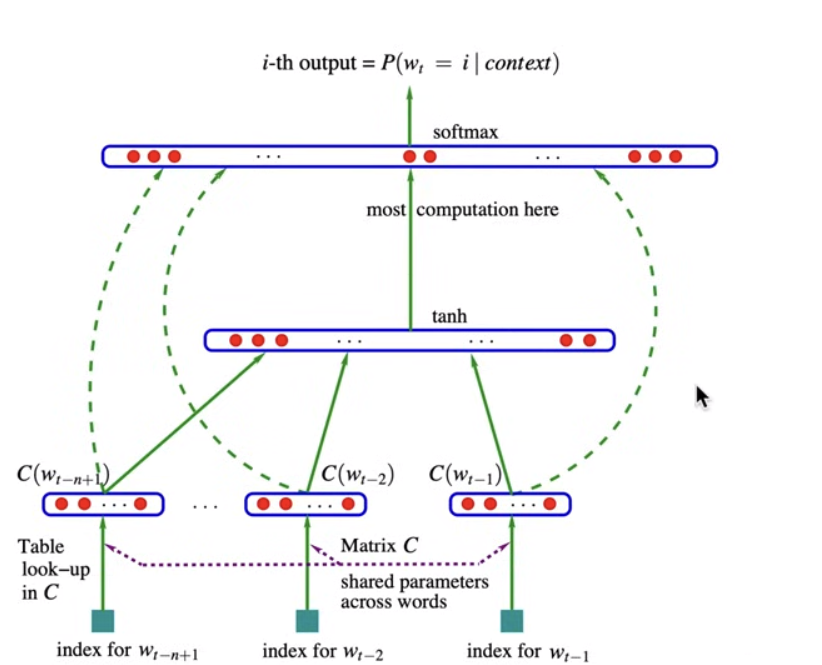

Figure explanation:

- Input part (3 words)
    - Taking 3 previous word and predict the fourth word
    - Each word -> 17000 possible word (vocabulary) and the index is int of 0-16999
    - There is a look-up table/embedding matrix C sized 17000 x 30 (17000 word and 30 dimension)
    - Setiap index word ngambil baris dari embedding matrix C. Each index converted to 30 dimension
    - Matrix C is shared across word, so there is 1 embedding matrix C and used to those 3 index
- Fully-connected hidden layer (tanh)
    - Size of the neural net is a hyperparameter, so we can choose the size by ourself
- Output layer (softmax)
    - There are 17000 words that could come next, so the number of the output layer is 17000 and all fully connected to hidden layer
    - The expensive layer

Parameters optimized using backpropagation:
- Weights and Biases on the layers
- Look up table

Parameters is optimized by trying to maximize the probability of the label word (the next word) with the respect of the NN parameters

In [282]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset and Building vocabulary

The included `names.txt` dataset, as an example, has the most common 32K names takes from [ssa.gov](https://www.ssa.gov/oact/babynames/) for the year 2018.

In [42]:
# Open the dataset (List of names) as a python list of strings which is words in this case
word= open('names.txt', 'r').read().splitlines()

In [43]:
#First 10 word
word[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [44]:
len(word)

32033

In [45]:
#Building vocabulary
chars=sorted(list(set(''.join(word))))
stoi={c:i+1 for i,c in enumerate(chars)} #Mapping of character to index
stoi['.']=0 #Start/End token
itos={i:c for c,i in stoi.items()} #Mapping of index to character
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building dataset + Split

In [232]:
#Breakdown of the dataset algorithm
block_size=3 #Context size: berapa karakter sebelum yang dipake buat predict selanjutnya
X, Y= [], []
for w in word: #First 5 words
    # print(w)
    context=[0]*block_size 
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print (''.join(itos[i] for i in context), '-->', itos[ix])
        context=context[1:]+[ix] #rolling window of the context, remove char in first idx and add new char in last idx

In [233]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [234]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

X ->int64-> [228146, 3] -> 228146 examples (data) and each input to NN is 3 int

Y ->int64-> [228146] -> int label

3 char --> label char

context --> label

In [235]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(word)
n1 = int(0.8*len(word))
n2 = int(0.9*len(word))

Xtr,  Ytr  = build_dataset(word[:n1])     # 80%
Xdev, Ydev = build_dataset(word[n1:n2])   # 10%
Xte,  Yte  = build_dataset(word[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [283]:
Xtr,Ytr,Xdev,Ydev,Xte,Yte=Xtr.to(device),Ytr.to(device),Xdev.to(device),Ydev.to(device),Xte.to(device),Yte.to(device)

### More complex MLP with activation, gradients, batch norm

Belajar lebih activation, gradients, batch norm untuk mempersiapkan move ke RNN

#### Before we start, the network is not properly configured at initialization

How to know?

Epoch 0, Loss 17.393760681152344

The first forward pass shows this loss is way too high

In training NN, we need to know the rough idea on how NN perform on init (what loss to expect)

So, the rough idea for this case is there are 27 possible output of characters. At init, the NN should be not know what character might likely to appear from given character so all 27 possible output have same chances to appear.

The prob dist at initialization should be an uniform distribution -> 1/27 for all 27 characters

In [14]:
#Initial loss should be
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [57]:
#proving it
logits=torch.zeros((1,27)) #All logits are zero (all logits are uniform then the result of all probability is 1/27)
probs=torch.softmax(logits, dim=1)
loss=-probs[:,1].log()
probs, loss

(tensor([[0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
          0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
          0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370]]),
 tensor([3.2958]))

see that the loss is the same as the 1/27


What happens is the weight init in NN creates a probability distribution that all messed up

In [31]:
#4d example
logits=torch.tensor([[-3.0, 5.0, 0.0, 2.0]])
probs=torch.softmax(logits, dim=1)
loss=-probs[:,2].log()
probs, loss

(tensor([[3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]]), tensor([5.0553]))

Some logits are in high/ there are extreme values so the loss is higher

In [32]:
#Try randn logits (normal distribution) so the logits are near zero
logits=torch.randn((1,27))
probs=torch.softmax(logits, dim=1)
loss=-probs[:,1].log()  
probs, loss

(tensor([[0.0331, 0.0248, 0.0246, 0.0081, 0.0110, 0.0447, 0.0110, 0.0117, 0.0196,
          0.0257, 0.0639, 0.0501, 0.0642, 0.0551, 0.0297, 0.0621, 0.0074, 0.0547,
          0.0324, 0.0344, 0.0651, 0.1291, 0.0234, 0.0421, 0.0406, 0.0177, 0.0140]]),
 tensor([3.6982]))

What we want is the logits is simetrical example all 0 to make it a uniform distribution

Where do we get logits -> from h W2 and b2

So to get all logits 0 first we need to remove the addition of the bias 2 at init and making W2 small at init

In [315]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

def train(test_mode=True):
    # MLP revisited
    n_embd = 10 # the dimensionality of the character embedding vectors
    n_hidden = 200 # the number of neurons in the hidden layer of the MLP
    vocab_size = len(itos)
    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    C  = torch.randn((vocab_size, n_embd),            generator=g)
    W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*0.2 #Reduce the W1 init for the operation pre act
    b1 = torch.randn(n_hidden,                        generator=g)*0.01 #Reduce the b1 to small number so the addition is small when operation pre act 
    W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01 #Reducing W2 init for logits calculation
    b2 = torch.randn(vocab_size,                      generator=g)*0  #Remove addition of b2 for logits calculation at initial state

    C,W1,b1,W2,b2 = C.to(device), W1.to(device), b1.to(device), W2.to(device), b2.to(device)
    
    parameters = [C, W1, b1, W2, b2]
    # print(sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True
        
    ms= 1 if test_mode==True else max_steps
    # print(test_mode)
    # print(ms)
    for i in range(ms):
        #Mini batch
        ix=torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]
        Xb, Yb = Xb.to(device), Yb.to(device)
        
        #Forward pass
        emb = C[Xb]
        embcat=emb.view(emb.shape[0],-1) #flatten the embedding to (batch_size, n_embd * block_size)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)  
        logits = h @ W2 + b2  
        loss = F.cross_entropy(logits, Yb) 
        
        #Backward pass
        for p in parameters:
            p.grad=None
        loss.backward()
        
        #Update parameters
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data -= lr*p.grad
        
        #Track stats
        if i % 1000 == 0:
            print(f'Step {i}, Loss {loss.item()}')
        lossi.append(loss.log10().item())
        
    return parameters, lossi

In [295]:
@torch.no_grad() # this decorator disables gradient tracking to the function below or use '''with torch.no_grad()''': to disable gradient tracking
def split_loss(split, parameters):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  C,W1,b1,W2,b2 = parameters
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat@W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
  return( h , (embcat@W1 + b1))

See changes made and the loss below

Before

In [258]:
_, _ = train(test_mode=True)

Step 0, Loss 26.54043960571289


Remove addition of b2 for logits calculation at initial state and making W2 small at init

In [263]:
_, _ = train(test_mode=True)

Step 0, Loss 4.159368515014648


It goes lower by removing the b2 at start and W2*0.1, if we do W2 * 0.01 it would get smaller loss too

But DO NOT WEIGHT ALL TO 0 , the random small number in weight is used for simetry breaking

Lets try to train it

In [277]:
parameters, lossi = train(test_mode=False)
C, W1, b1, W2, b2 = parameters

Step 0, Loss 4.159368515014648
Step 1000, Loss 2.457146644592285
Step 2000, Loss 2.350367307662964
Step 3000, Loss 2.13637638092041
Step 4000, Loss 1.9612630605697632
Step 5000, Loss 2.6387407779693604
Step 6000, Loss 1.6922399997711182
Step 7000, Loss 2.590129852294922
Step 8000, Loss 2.863058090209961
Step 9000, Loss 2.1536049842834473
Step 10000, Loss 2.7276270389556885
Step 11000, Loss 2.348543882369995
Step 12000, Loss 2.286926746368408
Step 13000, Loss 1.9312664270401
Step 14000, Loss 2.4176220893859863
Step 15000, Loss 2.6919186115264893
Step 16000, Loss 2.1267037391662598
Step 17000, Loss 2.319552421569824
Step 18000, Loss 2.0503616333007812
Step 19000, Loss 1.8130559921264648
Step 20000, Loss 2.5008647441864014
Step 21000, Loss 2.262211561203003
Step 22000, Loss 2.466129779815674
Step 23000, Loss 2.261843204498291
Step 24000, Loss 2.2655680179595947
Step 25000, Loss 2.4421448707580566
Step 26000, Loss 2.581401824951172
Step 27000, Loss 2.217189073562622
Step 28000, Loss 2.3652

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

def train(test_mode=True):
    # MLP revisited
    n_embd = 10 # the dimensionality of the character embedding vectors
    n_hidden = 200 # the number of neurons in the hidden layer of the MLP
    vocab_size = len(itos)
    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    C  = torch.randn((vocab_size, n_embd),            generator=g)
    W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*0.2 #Reduce the W1 init for the operation pre act
    b1 = torch.randn(n_hidden,                        generator=g)*0.01 #Reduce the b1 to small number so the addition is small when operation pre act 
    W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01 #Reducing W2 init for logits calculation
    b2 = torch.randn(vocab_size,                      generator=g)*0  #Remove addition of b2 for logits calculation at initial state

    C,W1,b1,W2,b2 = C.to(device), W1.to(device), b1.to(device), W2.to(device), b2.to(device)
    
    parameters = [C, W1, b1, W2, b2]
    # print(sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True
        
    ms= 1 if test_mode==True else max_steps
    # print(test_mode)
    # print(ms)
    for i in range(ms):
        #Mini batch
        ix=torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]
        Xb, Yb = Xb.to(device), Yb.to(device)
        
        #Forward pass
        emb = C[Xb]
        embcat=emb.view(emb.shape[0],-1) #flatten the embedding to (batch_size, n_embd * block_size)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)  
        logits = h @ W2 + b2  
        loss = F.cross_entropy(logits, Yb) 
        
        #Backward pass
        for p in parameters:
            p.grad=None
        loss.backward()
        
        #Update parameters
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data -= lr*p.grad
        
        #Track stats
        if i % 1000 == 0:
            print(f'Step {i}, Loss {loss.item()}')
        lossi.append(loss.log10().item())
        
    return parameters, lossi

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking to the function below or use '''with torch.no_grad()''': to disable gradient tracking
def split_loss(split, parameters):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  C,W1,b1,W2,b2 = parameters
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat@W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
  return( h , (embcat@W1 + b1))

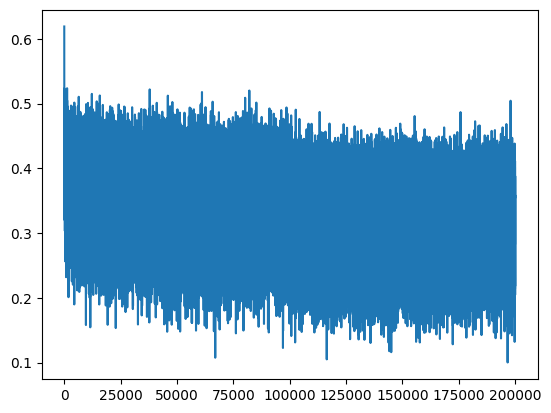

In [279]:
plt.plot(lossi)

Plot lossnya engga kayak kemaren yang seperti bentuk hockey stick

Kemaren kan lossnya tinggi banget terus beberapa iter awal itu mencoba untuk adjusment gede gede an biar lossnya terjun (Sepertinya weightsnya yang gede banget angkanya jadi turun)

In [296]:
split_loss('train', parameters)
h, hr=split_loss('val', parameters)

train 2.0677247047424316
val 2.1269078254699707


Train dan Val loss better karena kita lebih banyak steps/waktu ngurusin parameter NN yang udah pas, kalo yang hockey stick ada beberapa steps kebuang buat ngeberesin loss yang tinggi jadi rendah

Before:

tensor(2.1558) Train

tensor(2.2021) Val

This is good sign, the first loss is what we expect and the loss plot does not look like hockey stick

### But there are more problems in there (Tanh squashing)

The problem is in the Tanh -> The squashing function

In [288]:
h

tensor([[-1.0000,  0.5799, -0.5003,  ...,  0.9842,  1.0000,  1.0000],
        [-1.0000, -0.9979, -0.9865,  ..., -1.0000,  1.0000,  1.0000],
        [-1.0000, -0.9999,  0.9105,  ..., -1.0000,  1.0000,  1.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -0.9991,  0.9999,  1.0000],
        [ 0.9828,  0.4953, -1.0000,  ..., -0.7422, -0.6111,  0.2678],
        [ 0.8448,  0.3283, -0.6101,  ...,  0.9951, -1.0000,  1.0000]],
       device='cuda:0')

Banyak neuron yang outputnya 1 ato -1

Mari kita liat distribusinya

In [289]:
h.shape

torch.Size([22767, 200])

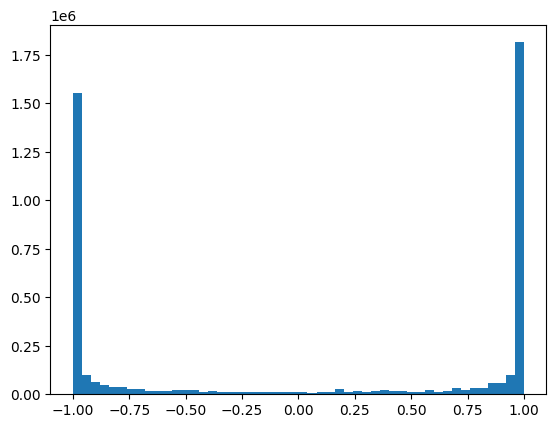

In [297]:
xxxx= h.view(-1).tolist() #flatten the hidden state to one large vector
plt.hist(xxxx, bins=50)
plt.show()

Illustration on how many h is one (white is 1)

32 examples and 200 neurons

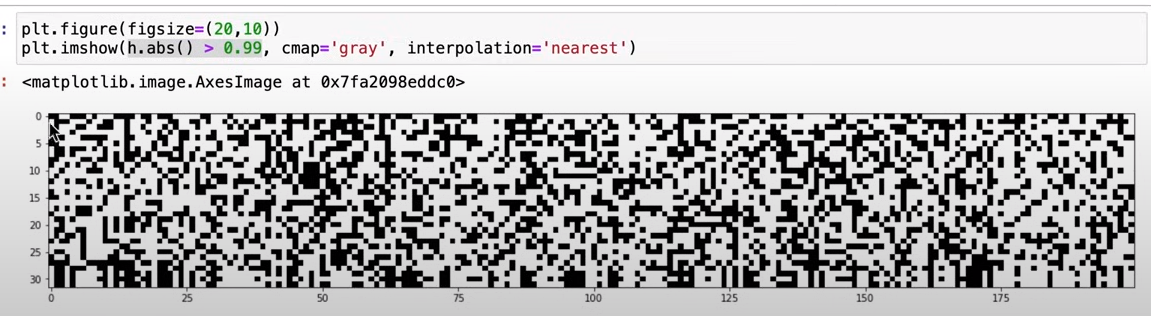

Bahaya kalo ada 1 kolom putih semua berarti itu adalah dead neuron, jadi data yang masuk ga ngaruh apa apa, dan neuronnya gakan belajar

Dead neuron -> whatever the data comes in, the neuron output always -1 or 1. So we trained less neuron

So, there are many h in 1 and -1

check why it happened

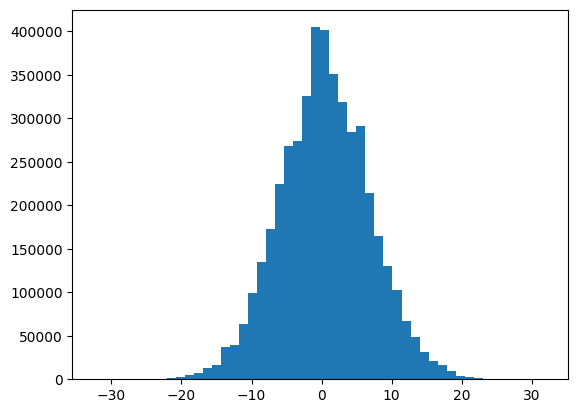

In [298]:
xxxx= hr.view(-1).tolist() #flatten the hidden state to one large vector
plt.hist(xxxx, bins=50)
plt.show()

Oke jadi pre activation (operasi di neuron).

It is very broad and tanh is squashing it to -1 and 1

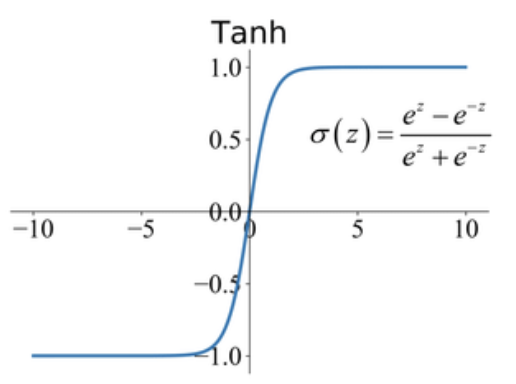

And there are many numbers that squashed into 1 and -1.

Those number are located in flat region (see the graph), so the gradient wont be much and it is an issue when backpropagating (vanishing grad), we killing the neuron to learn

This happens because of:

the weight init itself

or too much learning rate that kicks out the neuron out of place

Dead neuron -> whatever the data comes in, the neuron output always -1 or 1

Try this tanh(x)=1

gradient of tanh = (1 - tanh(x))

it would be 0 right? it is not impacting the loss and it is not adjusted when backpropagate

Dead neurons happen in other non linearity functions

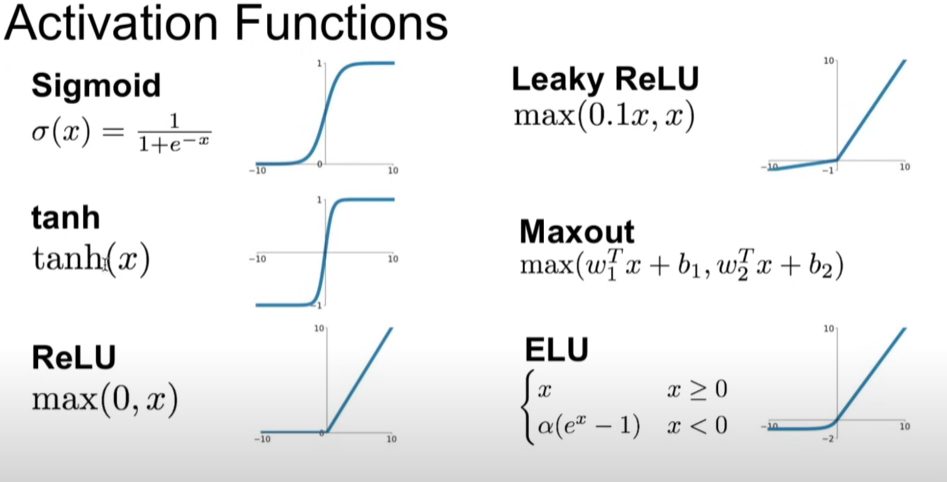

- Sigmoid jg sama squashing
- ReLU -> Below x=0 there are flat region -> the gradient 0 -> there is a problem named dying ReLU (Neuron is dead, never activates always output 0, so it never learning) . It can happen during init, by chance the weight made it dead or when training when the gradient is high and the learning rate is high, it optimizes the weight highly and kick the output to the dead region
- LeakyRELU may suffering this problem less

Let's fix the tanh:

operation pre act is including W1 and b1 so

- We can reduce the b1 to small number so the addition is small when operation pre act and adding variation to the NN

- Small weight init

In [311]:
#Lets try
parameters, lossi = train(test_mode=True)
C, W1, b1, W2, b2 = parameters

Step 0, Loss 3.296502113342285


In [312]:
split_loss('train', parameters)
h, hr=split_loss('val', parameters)

train 3.2911875247955322
val 3.291221857070923


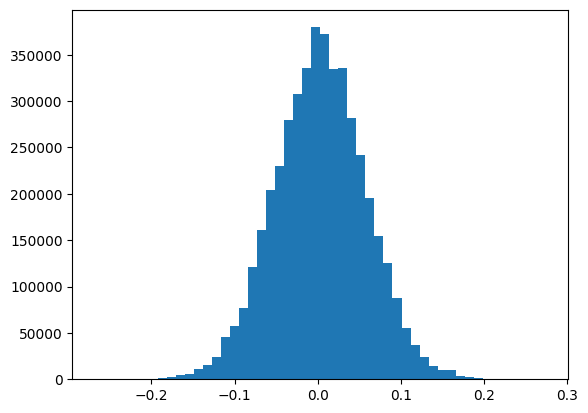

In [313]:
xxxx= h.view(-1).tolist() #flatten the hidden state to one large vector
plt.hist(xxxx, bins=50)
plt.show()

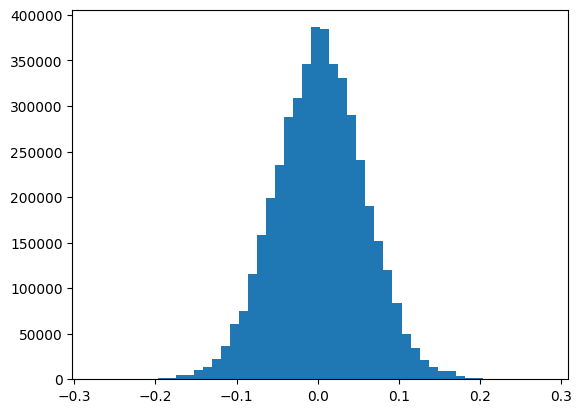

In [314]:
xxxx= hr.view(-1).tolist() #flatten the hidden state to one large vector
plt.hist(xxxx, bins=50)
plt.show()

Now we can see the distribution value after tanh and pre activation is better and in smaller range 

and there should be less white beacuse there are less value in 1 or -1 region after tanh
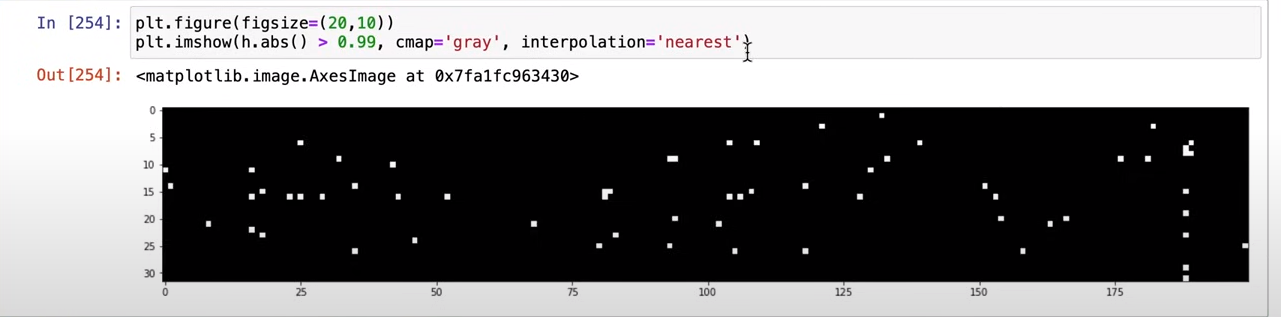

Let's train all

In [316]:
parameters, lossi = train(test_mode=False)
split_loss('train', parameters)
h, hr=split_loss('val', parameters)

Step 0, Loss 3.3090856075286865
Step 1000, Loss 2.4830706119537354
Step 2000, Loss 2.238556385040283
Step 3000, Loss 2.0850753784179688
Step 4000, Loss 1.9239356517791748
Step 5000, Loss 2.591921806335449
Step 6000, Loss 1.7827367782592773
Step 7000, Loss 2.4576735496520996
Step 8000, Loss 2.7157652378082275
Step 9000, Loss 2.1814334392547607
Step 10000, Loss 2.4061594009399414
Step 11000, Loss 2.3444933891296387
Step 12000, Loss 2.3208205699920654
Step 13000, Loss 1.9990020990371704
Step 14000, Loss 2.315784454345703
Step 15000, Loss 2.693098545074463
Step 16000, Loss 1.9615497589111328
Step 17000, Loss 2.242445945739746
Step 18000, Loss 1.948204517364502
Step 19000, Loss 1.7611359357833862
Step 20000, Loss 2.2719290256500244
Step 21000, Loss 2.173915147781372
Step 22000, Loss 2.3808810710906982
Step 23000, Loss 2.310175895690918
Step 24000, Loss 2.1493635177612305
Step 25000, Loss 2.339054822921753
Step 26000, Loss 2.43084716796875
Step 27000, Loss 2.1703739166259766
Step 28000, Loss

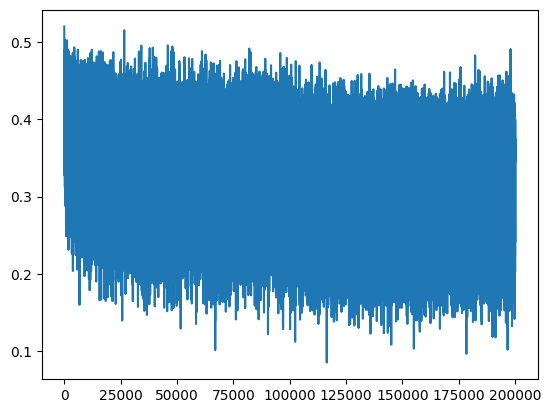

In [317]:
plt.plot(lossi)

Now lets recap

Original:

- tensor(2.1558) Train

- tensor(2.2021) Val

removing the b2 at start and W2*0.1, and we do W2 * 0.01, so the loss not like hockey stick:

- train 2.0677247047424316

- val 2.1269078254699707

fix tanh and vanishing gradient:

- train 2.0343821048736572

- val 2.102407455444336

### But, gada orang init begitu main coba coba scalingnya (kali 0.1 ato 0.01)

For context

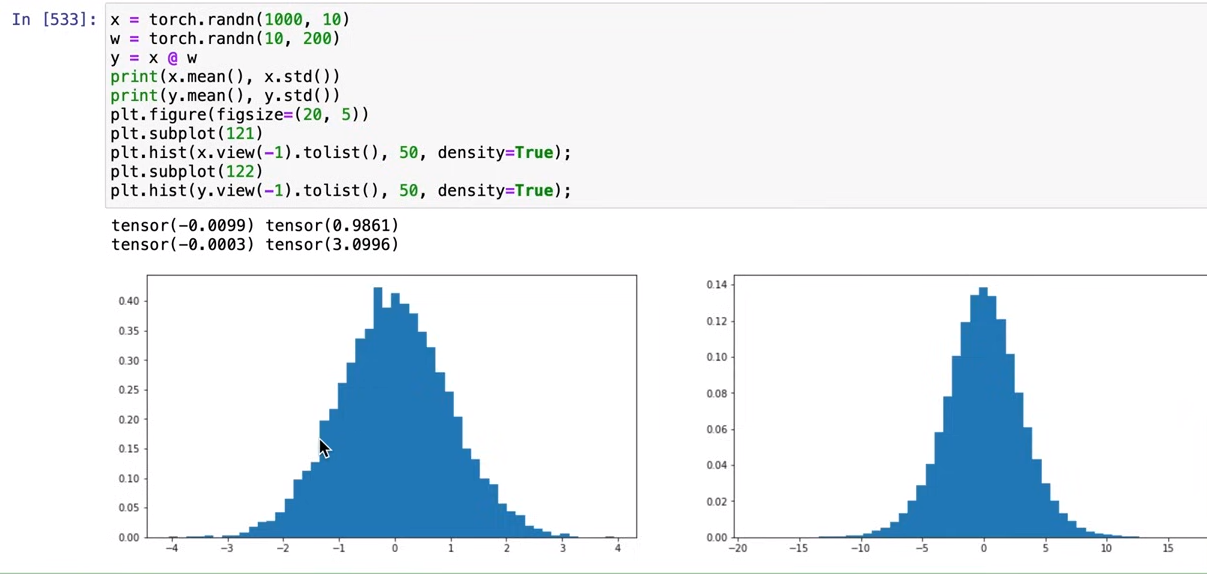

randn is a normal distribution random number which mean the mean is 0 and the std is 1

standar deviation (std) is a measure of the spread of the gaussian (Gunungannya itu)

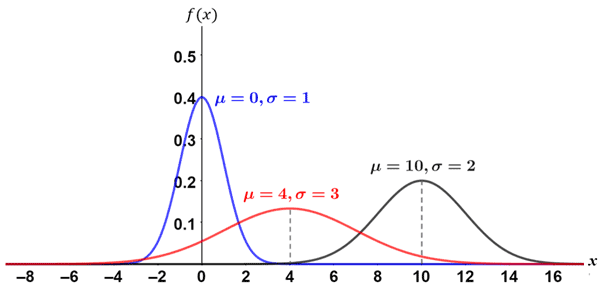

Take a look of the mean and the std

X => mean: tensor(-0.0099), std: tensor(0. 9861)

after multiplication

Y => mean: tensor(-0.0003), std: tensor(3.0996)

there is an increase in the std, the gaussian is spreading/expanding

but what we want to the most function has similar activation roughly throughout the neural net

so how we scale the w to perserve the distribution remained gaussian

in init if we scale down (multiply by 0.2) the W the std will go smaller. So the question is what number should multiply with the weight init to perserve std is 1

mathematically the answer is divide the weight at init with the square root of the fan_in(aka number of input going into the neuron) -> fan_in^0,5

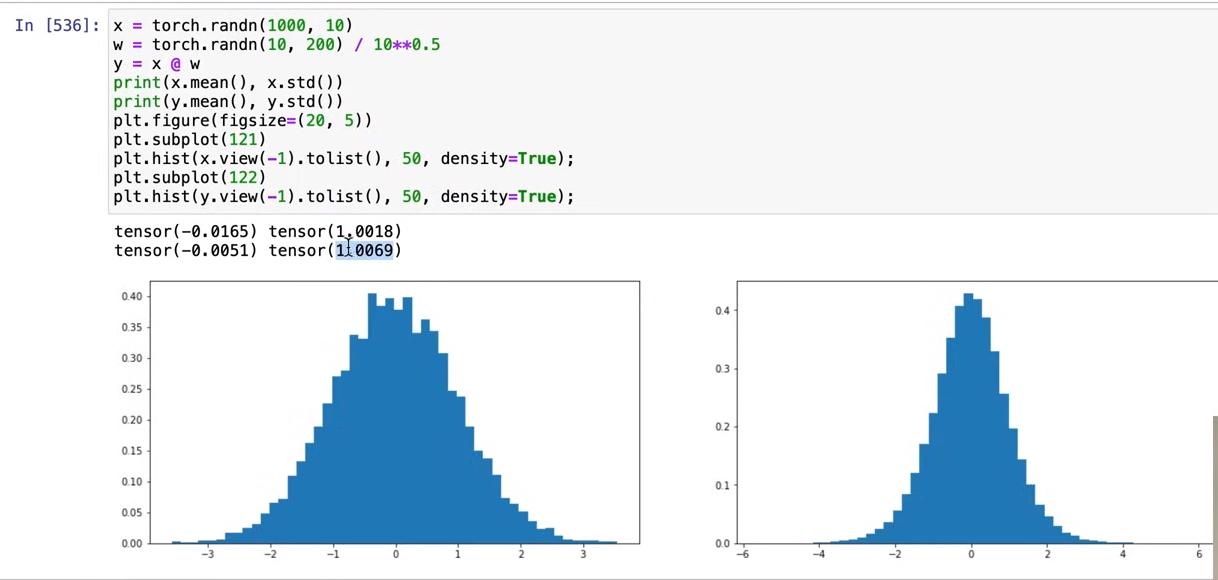

There is a paper called [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852)

This paper delves CNN and the ReLU function. ReLU squashes all negative input to 0 so half of distribution is thrown away so to compesate that they use this way on initializing the weight

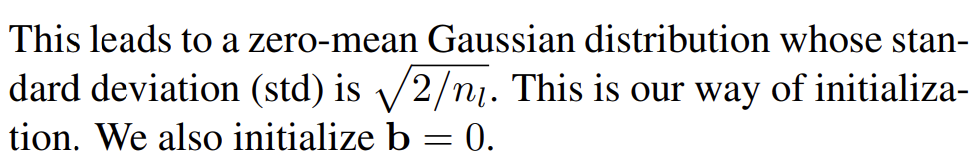

The init is W * sqrt(2/fan_in), the number 2 is used to compesate the half of the distribution that is squashed to 0 by the ReLU

This paper also studies the backpropagation, what they find is if the forward pass is properly initialized, the backward pass is approximately initialized

This kind of initialization is implemented in torch called **kaiming_normal_(He init)** which in sensei's opinion is the most common way to init a NN

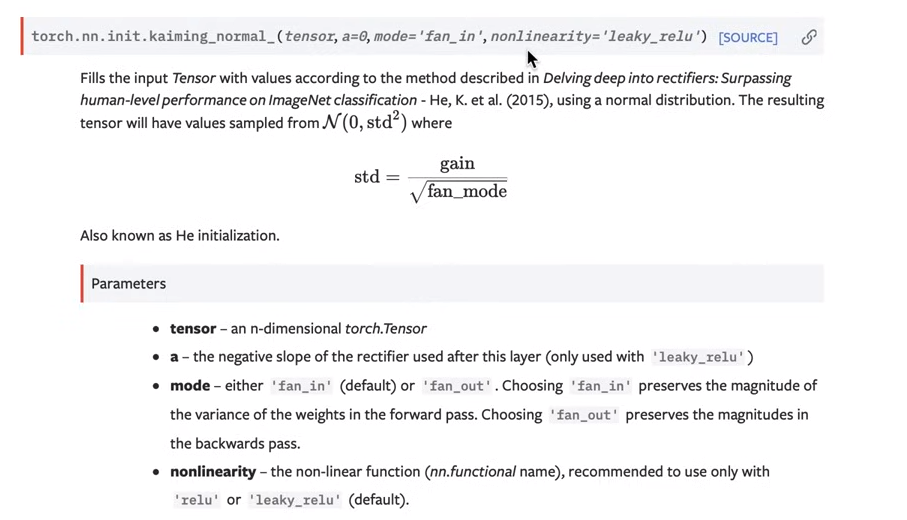

Important parameter:
- mode = fan_in or fan_out which one to optimize the activation or the gradient to normal dist. But it doesn't matter too much, so leave it at default (fan_in)
- nonlinearity = depending on the non-linearity, we need to compute the gain differently (like ReLU with gain 2)

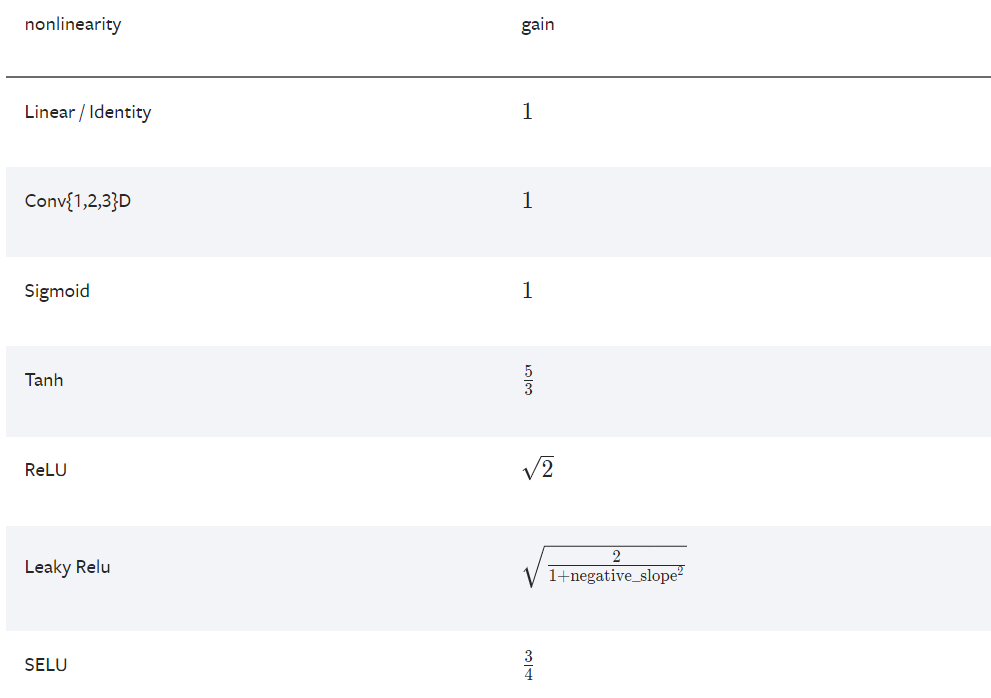

Tanh the advised gain is 5/3, tanh is contractive transformation so it squashes the output dist from the matmul(matrix multiplication) and squeeze it.

To counter the squash, we need to boost the weight a little bit so that we renormalize to the normal distribution

Today we do not need to very very careful with activations, gradients the ranges, and the historgram (like configuring the gain, etc) since there are inovations like Residual connections, use of normalization layers (layer normalization, batch norm layer, group normalization etc), much better optimizer not just SGD like RMSProp and Adam

So it makes less important to calibrate the inizialization correctly in NN. In practice, sensei just normalize the weight to the sqrt(fan_in)

the std will changes when we multiply the number

like randn init makes the std to 1 but when we multiply the randn init with 0.2 the std would be 0.2010

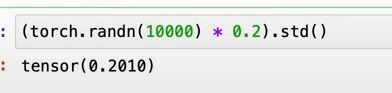

and then this is the std for tanh (example the fan_in is 30)

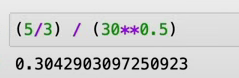

lets implement it

In [318]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

def train(test_mode=True):
    # MLP revisited
    n_embd = 10 # the dimensionality of the character embedding vectors
    n_hidden = 200 # the number of neurons in the hidden layer of the MLP
    vocab_size = len(itos)
    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    C  = torch.randn((vocab_size, n_embd),            generator=g)
    W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5) #kaiming he normal init configuration, n_embd * block_size is the fan_in which is 10 dimension * 3 block_size (word) which is 30
    b1 = torch.randn(n_hidden,                        generator=g)*0.01 #Reduce the b1 to small number so the addition is small when operation pre act 
    W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01 #Reducing W2 init for logits calculation
    b2 = torch.randn(vocab_size,                      generator=g)*0  #Remove addition of b2 for logits calculation at initial state

    C,W1,b1,W2,b2 = C.to(device), W1.to(device), b1.to(device), W2.to(device), b2.to(device)
    
    parameters = [C, W1, b1, W2, b2]
    # print(sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True
        
    ms= 1 if test_mode==True else max_steps
    # print(test_mode)
    # print(ms)
    for i in range(ms):
        #Mini batch
        ix=torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]
        Xb, Yb = Xb.to(device), Yb.to(device)
        
        #Forward pass
        emb = C[Xb]
        embcat=emb.view(emb.shape[0],-1) #flatten the embedding to (batch_size, n_embd * block_size)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)  
        logits = h @ W2 + b2  
        loss = F.cross_entropy(logits, Yb) 
        
        #Backward pass
        for p in parameters:
            p.grad=None
        loss.backward()
        
        #Update parameters
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data -= lr*p.grad
        
        #Track stats
        if i % 1000 == 0:
            print(f'Step {i}, Loss {loss.item()}')
        lossi.append(loss.log10().item())
        
    return parameters, lossi

In [319]:
@torch.no_grad() # this decorator disables gradient tracking to the function below or use '''with torch.no_grad()''': to disable gradient tracking
def split_loss(split, parameters):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  C,W1,b1,W2,b2 = parameters
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat@W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
  return( h , (embcat@W1 + b1))

In [320]:
#Lets try to train it
parameters, lossi = train(test_mode=False) 

Step 0, Loss 3.3128738403320312
Step 1000, Loss 2.4554479122161865
Step 2000, Loss 2.2340705394744873
Step 3000, Loss 2.052325487136841
Step 4000, Loss 1.9088562726974487
Step 5000, Loss 2.577765703201294
Step 6000, Loss 1.7512909173965454
Step 7000, Loss 2.4033212661743164
Step 8000, Loss 2.69049072265625
Step 9000, Loss 2.168808698654175
Step 10000, Loss 2.4228498935699463
Step 11000, Loss 2.3411707878112793
Step 12000, Loss 2.3524534702301025
Step 13000, Loss 1.9770961999893188
Step 14000, Loss 2.4032328128814697
Step 15000, Loss 2.7491936683654785
Step 16000, Loss 1.989753007888794
Step 17000, Loss 2.235846519470215
Step 18000, Loss 1.9833652973175049
Step 19000, Loss 1.7398960590362549
Step 20000, Loss 2.3509254455566406
Step 21000, Loss 2.1949191093444824
Step 22000, Loss 2.385477304458618
Step 23000, Loss 2.334444999694824
Step 24000, Loss 2.128621816635132
Step 25000, Loss 2.336333751678467
Step 26000, Loss 2.458735227584839
Step 27000, Loss 2.1689858436584473
Step 28000, Loss 

In [321]:
split_loss('train', parameters)
h, hr=split_loss('val', parameters)

train 2.0377535820007324
val 2.1032519340515137


Now nice we got similar loss, we have something that can we lean on to scale the weight init beside we just guessing the number by checking